
# ANTs × Cellpose Registration QC — Centroid Distances in µm

**Created:** 2025-10-15 12:22

**IMPORTANT:** ANTs transformations of NumPy arrays is finnicky. Export cellpose masks as TIFF instead and transform that to 2P space!

This notebook computes distances (in µm) between **cort-positive cell centroids** segmented by Cellpose in two modalities:
- **Confocal** (panneuronal GC + cort HCR in red) — *moving image* (registered to 2P)
- **2P** (panneuronal GC + cort::mCherry) — *fixed image*

The pipeline:
1. Load Cellpose `*_seg.npy` outputs and extract labeled masks.
2. Compute object centroids.
3. Convert pixel indices to physical units using voxel spacings (µm).
4. Apply the **confocal → 2P** ANTs transform to confocal centroids.
5. Match cells (nearest neighbor or Hungarian) and compute distances in µm.
6. Summaries and basic plots; optional gating to reject outliers.



## Requirements

- `numpy`, `pandas`, `scikit-image`, `scipy`, `matplotlib`
- `ants` (ANTsPy) **optional but recommended** for applying transforms inside Python.
  - If `ants` is not available, the notebook will export centroids to CSV and you can run
    `antsApplyTransformsToPoints` on the command line, then re-import the transformed CSV.

> Tip: For 3D Cellpose, pass correct anisotropy during segmentation to reduce z-bias.


## 0) User inputs

In [1]:

# --- Confocal inputs (moving) ---
CONF_LABEL_TIFF = "/Volumes/jlarsch/default/D2c/07_Data/Danin/Cellpose/trainingCort/hcr_test/L427_f02_round1_channel2_cort_gauss_cp_masks.tif"   # 16-bit Cellpose labels (Z,Y,X)
CONF_NRRD_PATH = "/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L427_f02/02_reg/00_preprocessing/r1/L427_f02_round1_channel2_cort.nrrd"

# --- 2P inputs (fixed) ---
TWOP_SEG_NPY = "/Users/ddharmap/dataProcessing/2p_HCR/data/L427_f02/L427_f02_anatomy_2P_cort_seg_anis1.npy"       # 2P *_seg.npy labels in fixed space
TWOP_NRRD_PATH = "/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L427_f02/02_reg/00_preprocessing/2p_anatomy/L427_f02_anatomy_2P_cort.nrrd"

# --- ANTs transforms (confocal -> 2P) ---
WARP_PATH   = "/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L427_f02/02_reg/01_r1-2p/transMatrices/L427_f02_round1_GCaMP_to_ref1Warp.nii.gz"
AFFINE_PATH = "/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L427_f02/02_reg/01_r1-2p/transMatrices/L427_f02_round1_GCaMP_to_ref0GenericAffine.mat"
INVERT_AFFINE = False  # set True if your affine requires inversion (fixed->moving stored on disk)

# --- Voxel spacings (µm) on 2P grid ---
VOX_2P = {"dz": 2.0, "dy": 0.6506220, "dx": 0.6506220}

# --- Matching parameters ---
MATCH_METHOD = "nn"    # "nn" for nearest neighbor, "hungarian" for 1–1 assignment
MAX_DISTANCE_UM = 5.0  # gate for valid matches (~1 soma diameter)
RANDOM_SEED = 42


## 1) Imports and helper functions

In [2]:
import os, sys, json, time
import numpy as np
import pandas as pd
from skimage.measure import regionprops_table
from scipy.spatial import cKDTree
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Dropdown
from IPython.display import display, HTML
from pathlib import Path
import tifffile as tiff

try:
    import ants
    HAVE_ANTSPY = True
except Exception as e:
    HAVE_ANTSPY = False
    print("ANTsPy not available; warp_label_tiff_with_ants requires ANTsPy.", e)

rng = np.random.default_rng(RANDOM_SEED)

def fs_info(path: str) -> dict:
    """Return basic filesystem info for a path."""
    exists = os.path.exists(path)
    size_b = os.path.getsize(path) if exists else None
    mtime = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(os.path.getmtime(path))) if exists else None
    return {"exists": exists, "size_bytes": size_b, "size_MB": (size_b/1e6 if size_b else None), "modified": mtime}

def physical_extent_um(mask: np.ndarray, vox: dict) -> tuple:
    """Return the physical field-of-view in µm for a labeled mask."""
    if mask.ndim == 3:
        Z, Y, X = mask.shape
        return (Z * vox["dz"], Y * vox["dy"], X * vox["dx"])
    Y, X = mask.shape
    return (Y * vox["dy"], X * vox["dx"])

def summarize_dataset(name: str, path: str, masks: np.ndarray, vox: dict) -> dict:
    """Single-row summary with metadata and basic statistics for a mask."""
    fs = fs_info(path)
    uniq = np.unique(masks)
    n_cells = int(uniq.size - (1 if uniq.size and uniq[0] == 0 else 0))
    row = {
        "dataset": name,
        "file": os.path.basename(path),
        "path": path,
        "exists": fs["exists"],
        "size_MB": fs["size_MB"],
        "modified": fs["modified"],
        "shape": tuple(masks.shape),
        "ndim": masks.ndim,
        "dtype": str(masks.dtype),
        "min_label": int(masks.min()),
        "max_label": int(masks.max()),
        "n_cells": n_cells,
        "voxel_um": (vox["dz"], vox["dy"], vox["dx"]) if masks.ndim == 3 else (vox["dy"], vox["dx"]),
        "FOV_um": tuple(round(v, 3) for v in physical_extent_um(masks, vox)),
        "n_voxels": int(masks.size),
        "anisotropy_z_over_y": (vox["dz"] / vox["dy"]) if masks.ndim == 3 else None,
    }
    return row

def load_cellpose_masks(seg_path: str) -> np.ndarray:
    """Load Cellpose *_seg.npy (dict) or raw label arrays."""
    if not os.path.exists(seg_path):
        raise FileNotFoundError(f"File not found: {seg_path}")
    try:
        obj = np.load(seg_path, allow_pickle=True)
    except Exception as e:
        raise OSError(f"Failed to load {seg_path}: {e}")
    if isinstance(obj, np.lib.npyio.NpzFile):
        if 'masks' in obj.files:
            return obj['masks']
        raise KeyError(f"{seg_path} (.npz) has no 'masks' entry. Keys: {obj.files}")
    if hasattr(obj, 'item'):
        dat = obj.item()
        masks = dat.get('masks')
        if masks is None:
            raise KeyError(f"'masks' not found in {seg_path}. Keys: {list(dat.keys())}")
        return masks
    if isinstance(obj, np.ndarray):
        return obj
    raise TypeError(f"Unexpected content in {seg_path}: {type(obj)}")

def mask_summary(mask: np.ndarray, name: str = "") -> dict:
    uniq = np.unique(mask)
    n_cells = int(uniq.size - (1 if uniq.size and uniq[0] == 0 else 0))
    return {
        "name": name,
        "shape": tuple(mask.shape),
        "ndim": mask.ndim,
        "dtype": str(mask.dtype),
        "min": int(mask.min()),
        "max": int(mask.max()),
        "n_cells": n_cells,
    }

def safe_slice(arr: np.ndarray, z: int) -> np.ndarray:
    if arr.ndim == 2:
        return arr
    z = int(np.clip(z, 0, arr.shape[0] - 1))
    return arr[z]

def _ants_clone_geometry(dst_img, like_img):
    dst_img.set_spacing(like_img.spacing)
    dst_img.set_origin(like_img.origin)
    dst_img.set_direction(like_img.direction)
    return dst_img

def warp_label_tiff_with_ants(
    tiff_path: str | Path,
    mov_img_int,
    fix_img_int,
    warp_path: str,
    affine_path: str,
    ants,
    vox_moving: dict | None = None,
    save_basename: str | None = None,
):
    """Warp a Cellpose label TIFF (Z,Y,X) into the fixed space using ANTs transforms."""
    tiff_path = Path(tiff_path)
    lab_zyx = tiff.imread(str(tiff_path))
    if lab_zyx.ndim != 3:
        raise ValueError(f"Expected 3D TIFF (Z,Y,X); got shape {lab_zyx.shape}")
    lab_xyz = np.transpose(lab_zyx, (2, 1, 0)).astype(np.int32, copy=False)
    mov_label_img = ants.from_numpy(lab_xyz)
    _ants_clone_geometry(mov_label_img, mov_img_int)
    if mov_label_img.shape != mov_img_int.shape:
        raise RuntimeError(
            f"Label XYZ shape {mov_label_img.shape} != moving intensity XYZ shape {mov_img_int.shape}."
        )
    if vox_moving is not None:
        dx, dy, dz = mov_img_int.spacing
        if not np.allclose([dx, dy, dz], [vox_moving["dx"], vox_moving["dy"], vox_moving["dz"]], atol=1e-6):
            print("[WARN] mov_img_int.spacing differs from provided vox_moving – using mov_img_int.spacing.")
    transformlist = [str(warp_path), str(affine_path)]
    whichtoinvert = [False, bool(INVERT_AFFINE)]
    warped_xyz = ants.apply_transforms(
        fixed=fix_img_int,
        moving=mov_label_img,
        transformlist=transformlist,
        whichtoinvert=whichtoinvert,
        interpolator="nearestNeighbor",
    ).numpy().astype(np.int32, copy=False)
    warped_zyx = np.transpose(warped_xyz, (2, 1, 0))
    if save_basename is None:
        save_basename = str(tiff_path.with_suffix("")) + "_in_fixed"
    out = {}
    max_id = int(warped_zyx.max())
    nz = int((warped_zyx > 0).sum())
    print(f"[warp_label_tiff_with_ants] warped shape(ZYX)={warped_zyx.shape} maxID={max_id} nonzero={nz}")
    if max_id <= 65535:
        out_tif = save_basename + "_labels_uint16.tif"
        tiff.imwrite(out_tif, warped_zyx.astype(np.uint16))
        out["tif"] = out_tif
    else:
        out_npy = save_basename + "_labels_int32.npy"
        np.save(out_npy, warped_zyx)
        out["npy"] = out_npy
        warped_img = ants.from_numpy(np.transpose(warped_zyx, (2, 1, 0)))
        _ants_clone_geometry(warped_img, fix_img_int)
        out_nii = save_basename + "_labels_int32.nii.gz"
        ants.image_write(warped_img, out_nii)
        out["nii"] = out_nii
    return warped_zyx, out

def array_sample_table(mask: np.ndarray, n: int = 20, name: str = "") -> pd.DataFrame:
    total = mask.size
    if total == 0:
        return pd.DataFrame({"dataset": [], "label": []})
    k = min(n, total)
    flat_idx = rng.choice(total, size=k, replace=False)
    coords = np.column_stack(np.unravel_index(flat_idx, mask.shape))
    values = mask.reshape(-1)[flat_idx]
    if mask.ndim == 3:
        cols = {'z': coords[:, 0], 'y': coords[:, 1], 'x': coords[:, 2]}
    else:
        cols = {'y': coords[:, 0], 'x': coords[:, 1]}
    cols['label'] = values
    cols['dataset'] = name
    df = pd.DataFrame(cols)
    return df[['dataset'] + [c for c in cols if c not in {'dataset'}]]

def compute_centroids(mask: np.ndarray) -> pd.DataFrame:
    props = regionprops_table(mask, properties=("label", "centroid"))
    df = pd.DataFrame(props)
    if mask.ndim == 3:
        df = df.rename(columns={"centroid-0": "z", "centroid-1": "y", "centroid-2": "x"})
    else:
        df = df.rename(columns={"centroid-0": "y", "centroid-1": "x"})
    return df

def idx_to_um(df_centroids: pd.DataFrame, vox: dict) -> np.ndarray:
    if 'z' in df_centroids.columns:
        arr = df_centroids[['z', 'y', 'x']].to_numpy(dtype=float)
        arr[:, 0] *= vox['dz']
        arr[:, 1] *= vox['dy']
        arr[:, 2] *= vox['dx']
        return arr
    arr = df_centroids[['y', 'x']].to_numpy(dtype=float)
    arr[:, 0] *= vox['dy']
    arr[:, 1] *= vox['dx']
    return arr

def nearest_neighbor_match(A_um: np.ndarray, B_um: np.ndarray):
    tree = cKDTree(B_um)
    dists, nn = tree.query(A_um)
    return dists, nn

def hungarian_match(A_um: np.ndarray, B_um: np.ndarray, max_cost=np.inf):
    cost = np.linalg.norm(A_um[:, None, :] - B_um[None, :, :], axis=2)
    row_ind, col_ind = linear_sum_assignment(cost)
    dists = cost[row_ind, col_ind]
    keep = dists <= max_cost
    return dists[keep], col_ind[keep], row_ind[keep]

def summarize_distances(dists: np.ndarray, valid_mask: np.ndarray) -> dict:
    if dists.size == 0:
        return {
            "n_pairs": 0,
            "within_gate": 0,
            "within_gate_frac": 0.0,
            "mean_um": None,
            "median_um": None,
            "p90_um": None,
            "p95_um": None,
            "max_um": None,
        }
    summary = {
        "n_pairs": int(dists.size),
        "within_gate": int(valid_mask.sum()),
        "within_gate_frac": float(valid_mask.mean()),
        "mean_um": float(np.mean(dists)),
        "median_um": float(np.median(dists)),
        "p90_um": float(np.percentile(dists, 90)),
        "p95_um": float(np.percentile(dists, 95)),
        "max_um": float(dists.max()),
    }
    return summary


In [3]:

if not HAVE_ANTSPY:
    raise ImportError("ANTsPy is required to warp the confocal label TIFF into 2P space.")

# Read the SAME images used for registration (geometry source of truth)
mov_img_int = ants.image_read(CONF_NRRD_PATH)  # moving intensity
fix_img_int = ants.image_read(TWOP_NRRD_PATH)  # fixed intensity

# Warp confocal labels (NN interpolation preserves cell IDs)
conf_labels_2p, out_paths = warp_label_tiff_with_ants(
    tiff_path=CONF_LABEL_TIFF,
    mov_img_int=mov_img_int,
    fix_img_int=fix_img_int,
    warp_path=WARP_PATH,
    affine_path=AFFINE_PATH,
    ants=ants,
    vox_moving=None,
    save_basename="confocal_labels_in_2P_space"
)

print("Saved:", out_paths)
print("Warped labels nonzero:", int((conf_labels_2p > 0).sum()))
print("Unique labels (<=20 shown):", np.unique(conf_labels_2p)[:20])


[warp_label_tiff_with_ants] warped shape(ZYX)=(196, 750, 750) maxID=191 nonzero=56237
Saved: {'tif': 'confocal_labels_in_2P_space_labels_uint16.tif'}
Warped labels nonzero: 56237
Unique labels (<=20 shown): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


## 2) Inspect datasets

Masks are represented by a .npy array (z, y, x, label) that represent the voxel location in space and to which cells they belong (0 = background). There should be non-zero labels if any cells are found by cellpose.

dataset,file,path,exists,size_MB,modified,shape,ndim,dtype,min_label,max_label,n_cells,voxel_um,FOV_um,n_voxels,anisotropy_z_over_y
2P (mCherry),L427_f02_anatomy_2P_cort_seg_anis1.npy,/Users/ddharmap/dataProcessing/2p_HCR/data/L427_f02/L427_f02_anatomy_2P_cort_seg_anis1.npy,True,2756.266,2025-10-06 09:32:37,"(196, 750, 750)",3,uint16,0,939,939,"(2.0, 0.650622, 0.650622)","(392.0, 487.967, 487.967)",110250000,3.073982


Saved table to input_datasets_overview.csv
Confocal label TIFF: /Volumes/jlarsch/default/D2c/07_Data/Danin/Cellpose/trainingCort/hcr_test/L427_f02_round1_channel2_cort_gauss_cp_masks.tif
  exists=True size_MB=1.617 modified=2025-10-23 13:26:03
Random voxel samples (2P labels):


dataset,z,y,x,label
2P,151,521,390,0
2P,140,469,116,0
2P,39,366,14,0
2P,191,166,356,0
2P,164,442,741,0
2P,149,137,397,0
2P,25,82,527,0
2P,17,369,665,0
2P,128,221,748,0
2P,100,444,228,0


Saved array_structure_samples.csv
Per-Z nonzero counts & preview (2P):


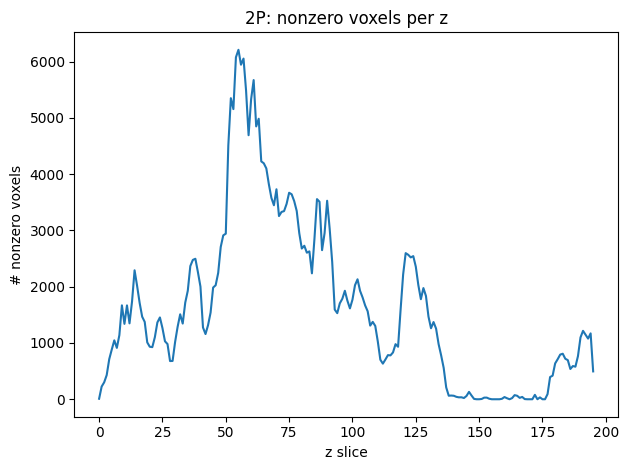

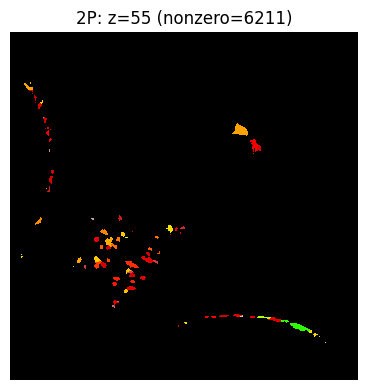

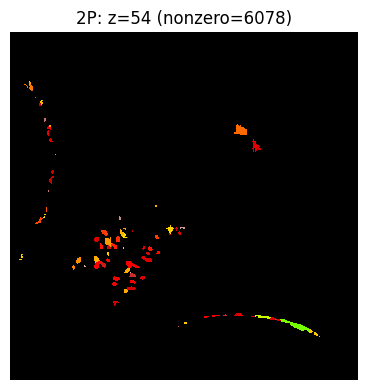

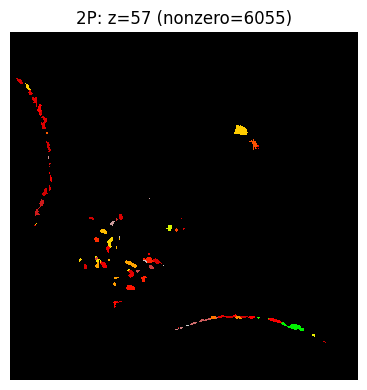

In [4]:

# ---- Inspect 2P segmentation (fixed space) ----
masks_2p = load_cellpose_masks(TWOP_SEG_NPY)

rows = [
    summarize_dataset("2P (mCherry)", TWOP_SEG_NPY, masks_2p, VOX_2P),
]
df_inputs = pd.DataFrame(rows)

# Display summary table
df_show = df_inputs.copy()
if "size_MB" in df_show.columns:
    df_show["size_MB"] = df_show["size_MB"].apply(lambda x: None if x is None else round(x, 3))
display(HTML(df_show.to_html(index=False).replace(
    "<table", '<table style="display:block; max-height:300px; overflow-y:auto; width:100%;"')))

df_inputs.to_csv("input_datasets_overview.csv", index=False)
print("Saved table to input_datasets_overview.csv")

conf_info = fs_info(CONF_LABEL_TIFF)
print(f"Confocal label TIFF: {CONF_LABEL_TIFF}")
print(f"  exists={conf_info['exists']} size_MB={None if conf_info['size_MB'] is None else round(conf_info['size_MB'], 3)} modified={conf_info['modified']}")

print("Random voxel samples (2P labels):")
df_2p_samp = array_sample_table(masks_2p, n=20, name="2P")
display(HTML(df_2p_samp.to_html(index=False).replace(
    "<table", '<table style="display:block; max-height:300px; overflow-y:auto; width:100%;"')))
df_2p_samp.to_csv("array_structure_samples.csv", index=False)
print("Saved array_structure_samples.csv")

def _plot_nz_per_z(mask, title_prefix):
    if mask.ndim != 3:
        return
    nz_per_z = (mask > 0).reshape(mask.shape[0], -1).sum(axis=1)
    plt.figure()
    plt.plot(np.arange(mask.shape[0]), nz_per_z)
    plt.xlabel("z slice"); plt.ylabel("# nonzero voxels")
    plt.title(f"{title_prefix}: nonzero voxels per z")
    plt.tight_layout(); plt.show()
    top = np.argsort(nz_per_z)[::-1][:3]
    for z in top:
        if nz_per_z[z] == 0:
            continue
        plt.figure(figsize=(4,4))
        plt.imshow(mask[z], cmap="nipy_spectral", interpolation="nearest")
        plt.title(f"{title_prefix}: z={z} (nonzero={int(nz_per_z[z])})")
        plt.axis("off"); plt.tight_layout(); plt.show()

print("Per-Z nonzero counts & preview (2P):")
_plot_nz_per_z(masks_2p, "2P")


## 3) Transform mask TIFF to 2P space

In [ ]:
# Read the SAME images used for registration (geometry source of truth)
mov_img_int = ants.image_read(CONF_NRRD_PATH)  # moving intensity
fix_img_int = ants.image_read(TWOP_NRRD_PATH)  # fixed intensity

# Run warp (NN labels, invert affine)
warped_labels_zyx, out_paths = warp_label_tiff_with_ants(
    tiff_path=CONF_LABEL_TIFF,
    mov_img_int=mov_img_int,
    fix_img_int=fix_img_int,
    warp_path=WARP_PATH,
    affine_path=AFFINE_PATH,
    ants=ants,
    vox_moving=None,                # optional; geometry is cloned from mov_img_int anyway
    save_basename="confocal_labels_in_2P_space"
)

print("Saved:", out_paths)

# Quick sanity prints
print("Warped labels nonzero:", int((warped_labels_zyx>0).sum()))
print("Unique labels (<=20 shown):", np.unique(warped_labels_zyx)[:20])

[warp_label_tiff_with_ants] warped shape(ZYX)=(196, 750, 750) maxID=191 nonzero=56237
Saved: {'tif': 'confocal_labels_in_2P_space_labels_uint16.tif'}
Warped labels nonzero: 56237
Unique labels (<=20 shown): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


## 4) Load Cellpose masks and compute centroids

In [5]:
from pathlib import Path
import tifffile as tiff

if "conf_labels_2p" not in globals():
    cached = Path("confocal_labels_in_2P_space_labels_uint16.tif")
    if cached.exists():
        print(f"Loading cached warp: {cached}")
        conf_labels_2p = tiff.imread(cached)  # uint16 stack in 2P space
    else:
        raise RuntimeError(
            "conf_labels_2p not defined and no cached warp found.\n"
            "Run the warp cell to generate the 2P-space confocal labels first."
        )

is3d = (conf_labels_2p.ndim == 3)
assert masks_2p.ndim == conf_labels_2p.ndim, "Confocal (warped) and 2P masks must have matching dimensionality."

df_conf = compute_centroids(conf_labels_2p)
df_2p   = compute_centroids(masks_2p)

print("Confocal→2P centroids:", df_conf.shape, "| 2P centroids:", df_2p.shape)
df_conf.head(), df_2p.head()

# Print concise summaries
for m, n in [(conf_labels_2p, "Confocal (warped→2P)"), (masks_2p, "2P (mCherry)")]:
    s = mask_summary(m, n)
    print(f"[{s['name']}] shape={s['shape']} ndim={s['ndim']} dtype={s['dtype']} "
          f"min={s['min']} max={s['max']} cells={s['n_cells']}")

assert masks_2p.ndim == 3 and conf_labels_2p.ndim == 3, "Viewer currently expects 3D stacks."

Z_conf = conf_labels_2p.shape[0]
Z_twoP = masks_2p.shape[0]
zmax = max(Z_conf, Z_twoP) - 1

def _browse_pair(z=0):
    zc = int(np.clip(z, 0, Z_conf-1))
    zt = int(np.clip(z, 0, Z_twoP-1))
    imc = safe_slice(conf_labels_2p, zc)
    imt = safe_slice(masks_2p,   zt)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
    axL, axR = axes

    im0 = axL.imshow(imc, cmap="nipy_spectral", interpolation="nearest")
    axL.set_title(f"Confocal→2P Z={zc}/{Z_conf-1}  shape={imc.shape}")
    axL.axis("off")

    im1 = axR.imshow(imt, cmap="nipy_spectral", interpolation="nearest")
    axR.set_title(f"2P (mCherry) Z={zt}/{Z_twoP-1}  shape={imt.shape}")
    axR.axis("off")

    vmax = max(imc.max(), imt.max())
    im0.set_clim(0, vmax)
    im1.set_clim(0, vmax)

    plt.show()

interact(
    _browse_pair,
    z=IntSlider(min=0, max=zmax, step=1, value=min(Z_conf, Z_twoP)//2, description="z-plane"),
);


Confocal→2P centroids: (184, 4) | 2P centroids: (939, 4)
[Confocal (warped→2P)] shape=(196, 750, 750) ndim=3 dtype=int32 min=0 max=191 cells=184
[2P (mCherry)] shape=(196, 750, 750) ndim=3 dtype=uint16 min=0 max=939 cells=939


interactive(children=(IntSlider(value=98, description='z-plane', max=195), Output()), _dom_classes=('widget-in…

## 5) Convert centroids to physical units (µm)

In [6]:

P_conf_in_2p_um = idx_to_um(df_conf, VOX_2P)
P_2p_um         = idx_to_um(df_2p,   VOX_2P)
print(f"P_conf_in_2p_um shape: {P_conf_in_2p_um.shape}, P_2p_um shape: {P_2p_um.shape}")


P_conf_in_2p_um shape: (184, 3), P_2p_um shape: (939, 3)


## 6) Match cells and compute distances

In [7]:
if P_conf_in_2p_um is None:
    raise RuntimeError("Transformed confocal centroids not available yet. Complete the ANTs step then re-run.")

labels_conf = df_conf["label"].to_numpy()
labels_2p   = df_2p["label"].to_numpy()

# --- matching ---
if MATCH_METHOD == "nn":
    dists, nn = nearest_neighbor_match(P_conf_in_2p_um, P_2p_um)
    matched_twoP_labels = labels_2p[nn]
    matched_conf_labels = labels_conf
elif MATCH_METHOD == "hungarian":
    dists, col_ind, row_ind = hungarian_match(P_conf_in_2p_um, P_2p_um, max_cost=np.inf)
    matched_conf_labels = labels_conf[row_ind]
    matched_twoP_labels = labels_2p[col_ind]
else:
    raise ValueError("MATCH_METHOD must be 'nn' or 'hungarian'")

# --- construct table ---
valid = dists <= MAX_DISTANCE_UM
matches = pd.DataFrame({
    "conf_label": matched_conf_labels,
    "twoP_label": matched_twoP_labels,
    "distance_um": dists,
    "within_gate": valid
}).sort_values("distance_um", ascending=True).reset_index(drop=True)

# --- display (scrollable HTML table) ---
# display(HTML(matches.to_html(index=False, max_rows=30, escape=False, notebook=True)))
# replace the display() line with this one-liner:
display(HTML(matches.to_html(index=False).replace(
    "<table", '<table style="display:block; max-height:600px; overflow-y:auto; width:100%;"')))

# --- summary stats ---
summary = summarize_distances(dists, valid)
print("Summary:", json.dumps(summary, indent=2))

# --- optional: save ---
matches.to_csv("centroid_matches_sorted.csv", index=False)
print("Saved centroid_matches_sorted.csv")

conf_label,twoP_label,distance_um,within_gate
189,835,0.359880,True
50,279,0.595609,True
167,582,0.636246,True
174,615,0.684944,True
104,551,1.246808,True
184,799,1.574596,True
154,647,1.608847,True
92,340,1.635147,True
169,655,1.863940,True
188,806,1.990348,True


Summary: {
  "n_pairs": 184,
  "within_gate": 68,
  "within_gate_frac": 0.3695652173913043,
  "mean_um": 8.625155938930538,
  "median_um": 6.543797859264881,
  "p90_um": 16.8430609945727,
  "p95_um": 20.93157808695196,
  "max_um": 48.931771080874086
}
Saved centroid_matches_sorted.csv


In [25]:
import plotly.graph_objects as go

def _build_centroid_table():
    conf_df = df_conf[['label', 'z', 'y', 'x']].copy()
    conf_df['source'] = 'Confocal→2P'
    conf_df['z_um'] = P_conf_in_2p_um[:, 0]
    conf_df['y_um'] = P_conf_in_2p_um[:, 1]
    conf_df['x_um'] = P_conf_in_2p_um[:, 2]

    twoP_df = df_2p[['label', 'z', 'y', 'x']].copy()
    twoP_df['source'] = '2P'
    twoP_df['z_um'] = P_2p_um[:, 0]
    twoP_df['y_um'] = P_2p_um[:, 1]
    twoP_df['x_um'] = P_2p_um[:, 2]

    conf_lookup = matches.set_index('conf_label')
    conf_df['distance_um'] = conf_df['label'].map(conf_lookup['distance_um'])
    conf_df['within_gate'] = conf_df['label'].map(conf_lookup['within_gate'])
    conf_df['matched_twoP_label'] = conf_df['label'].map(conf_lookup['twoP_label'])

    twoP_lookup = (
        matches.sort_values('distance_um')
               .drop_duplicates('twoP_label', keep='first')
               .set_index('twoP_label')
    )
    twoP_df['distance_um'] = twoP_df['label'].map(twoP_lookup['distance_um'])
    twoP_df['within_gate'] = twoP_df['label'].map(twoP_lookup['within_gate'])
    twoP_df['matched_conf_label'] = twoP_df['label'].map(twoP_lookup['conf_label'])

    centroids = pd.concat([conf_df, twoP_df], ignore_index=True)
    centroids['within_gate'] = centroids['within_gate'].fillna(False)
    centroids['distance_um'] = centroids['distance_um'].astype(float)
    return centroids

centroids = _build_centroid_table()

def _scatter_traces(metric):
    traces = []
    for source, symbol in [('Confocal→2P', 'circle'), ('2P', 'square')]:
        df = centroids[centroids['source'] == source]
        marker = dict(
            size=5.0 if source == 'Confocal→2P' else 3.8,
            symbol=symbol,
            opacity=0.85 if source == 'Confocal→2P' else 0.65,
        )

        showscale = False
        colorbar = None

        if metric == 'within_gate':
            marker['color'] = ['#2ecc71' if flag else '#e74c3c'
                               for flag in df['within_gate']]
        elif metric == 'source':
            marker['color'] = ['#1f77b4' if source == 'Confocal→2P' else '#ff7f0e'] * len(df)
        elif metric == 'distance_um':
            clipped = np.clip(df['distance_um'].fillna(0).to_numpy(), 0, 10)
            marker['color'] = clipped.tolist()
            marker['colorscale'] = 'Viridis'
            marker['cmin'] = 0
            marker['cmax'] = 10
            showscale = True
            colorbar = dict(title='distance (µm)', tickvals=[0, 2, 4, 6, 8, 10])
        elif metric == 'z_um':
            marker['color'] = df['z_um'].tolist()
            marker['colorscale'] = 'Plasma'
            showscale = True
            colorbar = dict(title='z (µm)')
        else:
            marker['color'] = df[metric].tolist()
            marker['colorscale'] = 'Viridis'
            showscale = True
            colorbar = dict(title=metric)

        marker['showscale'] = showscale and source == 'Confocal→2P'
        if colorbar and source == 'Confocal→2P':
            marker['colorbar'] = colorbar

        partner = (
            df['matched_twoP_label'].fillna(df['matched_conf_label'])
            if 'matched_twoP_label' in df
            else df['matched_conf_label']
        ).fillna(-1).astype(int).to_numpy()

        custom = np.stack([
            df['source'].to_numpy(),
            df['label'].to_numpy(),
            df['distance_um'].fillna(-1.0).to_numpy(),
            partner,
        ], axis=1)

        traces.append(go.Scatter3d(
            x=df['x_um'],
            y=df['y_um'],
            z=df['z_um'],
            mode='markers',
            marker=marker,
            customdata=custom,
            hovertemplate=(
                "source: %{customdata[0]}<br>"
                "label: %{customdata[1]}<br>"
                "x,y,z (µm): %{x:.2f}, %{y:.2f}, %{z:.2f}<br>"
                "distance (µm): %{customdata[2]:.2f}<br>"
                "matched label: %{customdata[3]}<extra></extra>"
            ),
            name=source,
        ))
    return traces

# Build traces for each metric (objects, not JSON)
all_traces = []
trace_index = {}
metrics = ['within_gate', 'distance_um', 'z_um', 'source']

for metric in metrics:
    tr_pair = _scatter_traces(metric)
    idx0 = len(all_traces)
    all_traces.extend(tr_pair)
    trace_index[metric] = [idx0, idx0 + 1]

visible = [False] * len(all_traces)
for i in trace_index[metrics[0]]:
    visible[i] = True
for i, tr in enumerate(all_traces):
    tr.visible = visible[i]

fig = go.Figure(data=all_traces)

buttons = []
for metric in metrics:
    vis = [False] * len(all_traces)
    for i in trace_index[metric]:
        vis[i] = True
    buttons.append(dict(
        label=f"Color by: {metric}",
        method="update",
        args=[
            {"visible": vis},
            {"title": f"Centroid cloud — color by {metric}"},
        ],
    ))

fig.update_layout(
    width=1500,
    height=1000,
    title=f"Centroid cloud — color by {metrics[0]}",
    scene=dict(
        xaxis_title="x (µm)",
        yaxis_title="y (µm)",
        zaxis_title="z (µm)",
        aspectmode="data",
    ),
    legend=dict(x=0.02, y=0.70, font=dict(size=10)),
    updatemenus=[dict(
        type="dropdown",
        direction="down",
        x=1.05,
        y=0.95,
        showactive=True,
        xanchor="left",
        yanchor="top",
        buttons=buttons,
    )],
)

fig.show()


/var/folders/qg/mcw76_dj3gq7p4vz0sd2w_hh0000gn/T/ipykernel_69402/3872909055.py:31: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [18]:
for metric, traces in trace_sets.items():
    print(f"\n=== {metric} ===")
    for i, tr in enumerate(traces):
        marker = tr["marker"]
        color = marker.get("color")
        if isinstance(color, list):
            sample = color[:5]
            span = (min(color), max(color)) if color else (None, None)
            print(f" trace {i}: {len(color)} colors, sample={sample}, range={span}")
        else:
            print(f" trace {i}: single color value -> {color}")



=== within_gate ===
 trace 0: 184 colors, sample=['#e74c3c', '#e74c3c', '#e74c3c', '#e74c3c', '#e74c3c'], range=('#2ecc71', '#e74c3c')
 trace 1: 939 colors, sample=['#e74c3c', '#e74c3c', '#e74c3c', '#e74c3c', '#e74c3c'], range=('#2ecc71', '#e74c3c')

=== distance_um ===
 trace 0: 184 colors, sample=[11.139382557173535, 9.278213543741725, 6.238806544888445, 10.032243654970427, 13.933796711044947], range=(0.3598801315483792, 48.931771080874086)
 trace 1: 939 colors, sample=[nan, nan, nan, nan, nan], range=(nan, nan)

=== source ===
 trace 0: 184 colors, sample=['#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4'], range=('#1f77b4', '#1f77b4')
 trace 1: 939 colors, sample=['#ff7f0e', '#ff7f0e', '#ff7f0e', '#ff7f0e', '#ff7f0e'], range=('#ff7f0e', '#ff7f0e')

=== z_um ===
 trace 0: 184 colors, sample=[105.53878020713464, 112.68575323790047, 108.30331753554502, 106.76939539860888, 97.33333333333333], range=(82.19718309859155, 253.0)
 trace 1: 939 colors, sample=[2.7222222222222223, 7.0895

## 7) Plots

In [ ]:

# Distance histogram
from ipywidgets import interact, FloatSlider

distances = matches["distance_um"].to_numpy()
n_pairs = distances.size
default_gate = MAX_DISTANCE_UM
gate_max = float(distances.max()) * 1.05 if n_pairs else default_gate

@interact(
    gate_um=FloatSlider(
        value=default_gate,
        min=0.0,
        max=gate_max,
        step=0.5,
        description="gate (µm)",
        readout_format=".1f",
    )
)
def plot_distance_hist(gate_um):
    within = int((distances <= gate_um).sum())
    frac = within / n_pairs if n_pairs else 0.0

    plt.figure(figsize=(20, 5))
    plt.hist(distances, bins=500, color="steelblue", alpha=0.85)
    plt.axvline(
        gate_um,
        color="red",
        linestyle="--",
        linewidth=1.6,
        label=f"gate = {gate_um:.2f} µm",
    )

    plt.xlabel("Centroid distance (µm)")
    plt.ylabel("Count")
    plt.title("Distribution of centroid distances")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"within_gate: {within} / {n_pairs}  ({frac:.1%})")




interactive(children=(FloatSlider(value=5.0, description='gate (µm)', max=51.37835963491779, readout_format='.…

In [ ]:
try:
    from ipywidgets import interact, FloatSlider, FloatLogSlider, Checkbox
except Exception as e:
    print("ipywidgets not available:", e)
    raise

# convenience projections
Z2, Y2, X2 = P_2p_um[:,0], P_2p_um[:,1], P_2p_um[:,2]
Zc, Yc, Xc = P_conf_in_2p_um[:,0], P_conf_in_2p_um[:,1], P_conf_in_2p_um[:,2]

zmin = float(min(Z2.min(), Zc.min()))
zmax = float(max(Z2.max(), Zc.max()))
default_thick = 4.0  # µm half-thickness on each side of the slider plane

def _plot_slice(z_um=0.0, thickness_um=default_thick, show_conf=True, show_2p=True, show_matches=False):
    plt.figure()
    # 2P points in the slab
    if show_2p:
        m2 = np.abs(Z2 - z_um) <= thickness_um
        plt.scatter(X2[m2], Y2[m2], s=8, label="2P", alpha=0.9)
    # confocal→2P points in the slab
    if show_conf:
        mc = np.abs(Zc - z_um) <= thickness_um
        plt.scatter(Xc[mc], Yc[mc], s=8, alpha=0.6, label="Conf→2P")
    # optional: draw match lines for pairs whose both endpoints fall in the slab
    if show_matches and 'matches' in globals():
        # build quick label→coord maps
        coord_2p = dict(zip(df_2p["label"].to_numpy(), P_2p_um))
        coord_conf = dict(zip(df_conf["label"].to_numpy(), P_conf_in_2p_um))
        for _, row in matches.iterrows():
            a = coord_conf.get(int(row["conf_label"]))
            b = coord_2p.get(int(row["twoP_label"]))
            if a is None or b is None:
                continue
            if (abs(a[0]-z_um) <= thickness_um) and (abs(b[0]-z_um) <= thickness_um):
                plt.plot([a[2], b[2]], [a[1], b[1]], linewidth=0.5)

    plt.gca().invert_yaxis()
    plt.xlabel("x (µm)")
    plt.ylabel("y (µm)")
    plt.title(f"Centroids near z = {z_um:.2f} µm (±{thickness_um:.2f})")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

interact(
    _plot_slice,
    z_um=FloatSlider(min=zmin, max=zmax, step=0.5, value=(zmin+zmax)/2, description="z (µm)"),
    thickness_um=FloatSlider(min=0.5, max=20.0, step=0.5, value=default_thick, description="slab ±µm"),
    show_conf=Checkbox(value=True, description="show Conf→2P"),
    show_2p=Checkbox(value=True, description="show 2P"),
    show_matches=Checkbox(value=False, description="show match lines"),
);

interactive(children=(FloatSlider(value=195.90277777777777, description='z (µm)', max=389.0833333333333, min=2…

## 8) Save results

In [ ]:

out_matches_csv = "centroid_matches.csv"
matches.to_csv(out_matches_csv, index=False)
print(f"Wrote {out_matches_csv}")

out_summary_json = "qc_summary.json"
with open(out_summary_json, "w") as f:
    json.dump(summary, f, indent=2)
print(f"Wrote {out_summary_json}")


Wrote centroid_matches.csv
Wrote qc_summary.json



## Notes & Tips

- **Transform direction**: These steps assume your ANTs transform maps *confocal → 2P*. If your files represent the reverse direction, invert them or swap roles.
- **Gate selection**: Start with ~1 soma diameter (e.g., 8–12 µm for juvenile zebrafish thalamus). Report fraction within gate, median, p90.
- **Outliers**: Investigate > gate by cropping around predicted pairs; often due to segmentation misses or local warp strain.
- **Warp health**: Consider computing a log-Jacobian image from the SyN warp and correlating distance outliers with high-deformation regions.
- **Reproducibility**: Keep a copy of your exact `VOX_*`, transform filenames, and Cellpose versions alongside the outputs.
